<a href="https://colab.research.google.com/github/PhilippMatthes/diplom/blob/master/src/shl-deep-learning-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a deep CNN to directly classify SHL timeseries data

The following notebook contains code to classify SHL timeseries data with deep convolutional neural networks. This is devided into the following steps:

1. Download the SHL dataset.
2. Preprocess the SHL dataset into features and make it readable efficiently by our training engine.
3. Define one or multiple ml models.
4. Train the model(s) and utilize grid search to find the best configuration.
5. Export the models and their training parameters for later analysis.

In [1]:
# Free up some disk space on colab
!rm -rf /usr/local/lib/python2.7
!rm -rf /swift
!rm -rf /usr/local/lib/python3.6/dist-packages/torch
!rm -rf /usr/local/lib/python3.6/dist-packages/pystan
!rm -rf /usr/local/lib/python3.6/dist-packages/spacy
!rm -rf /tensorflow-1.15.2/

In [2]:
# Get needed auxiliary files for colab
!git clone https://github.com/philippmatthes/diplom

Cloning into 'diplom'...
remote: Enumerating objects: 1755, done.
remote: Counting objects: 100% (1092/1092), done.
remote: Compressing objects: 100% (734/734), done.
remote: Total 1755 (delta 542), reused 817 (delta 301), pack-reused 663
Receiving objects: 100% (1755/1755), 34.53 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (918/918), done.


In [1]:
# Change into src dir and load our datasets
%cd /content/diplom/src
!mkdir shl-dataset

/content/diplom/src
mkdir: cannot create directory ‘shl-dataset’: File exists


In [4]:
# Download training datasets
!wget -nc -O shl-dataset/challenge-2019-train_torso.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_torso.zip
!wget -nc -O shl-dataset/challenge-2019-train_bag.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_bag.zip
!wget -nc -O shl-dataset/challenge-2019-train_hips.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_hips.zip
!wget -nc -O shl-dataset/challenge-2020-train_hand.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-train_hand.zip
# Download validation dataset
!wget -nc -O shl-dataset/challenge-2020-validation.zip http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/challenge-2020-validation.zip

--2021-08-19 09:37:33--  http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_torso.zip
Resolving www.shl-dataset.org (www.shl-dataset.org)... 37.187.125.22
Connecting to www.shl-dataset.org (www.shl-dataset.org)|37.187.125.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5852446972 (5.5G) [application/zip]
Saving to: ‘shl-dataset/challenge-2019-train_torso.zip’

shl-dataset/challen 100%[===================>]   5.45G  7.41MB/s    in 12m 6s  

2021-08-19 09:49:39 (7.69 MB/s) - ‘shl-dataset/challenge-2019-train_torso.zip’ saved [5852446972/5852446972]

--2021-08-19 09:49:39--  http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2019/challenge-2019-train_bag.zip
Resolving www.shl-dataset.org (www.shl-dataset.org)... 37.187.125.22
Connecting to www.shl-dataset.org (www.shl-dataset.org)|37.187.125.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5628524721 (5.2G) [application/zip]
Saving to: ‘shl-data

In [5]:
# Unzip training datasets
!unzip -n -d shl-dataset/challenge-2019-train_torso shl-dataset/challenge-2019-train_torso.zip
!rm shl-dataset/challenge-2019-train_torso.zip
!unzip -n -d shl-dataset/challenge-2019-train_bag shl-dataset/challenge-2019-train_bag.zip
!rm shl-dataset/challenge-2019-train_bag.zip
!unzip -n -d shl-dataset/challenge-2019-train_hips shl-dataset/challenge-2019-train_hips.zip
!rm shl-dataset/challenge-2019-train_hips.zip
!unzip -n -d shl-dataset/challenge-2020-train_hand shl-dataset/challenge-2020-train_hand.zip
!rm shl-dataset/challenge-2020-train_hand.zip
# Unzip validation dataset
!unzip -n -d shl-dataset/challenge-2020-validation shl-dataset/challenge-2020-validation.zip
!rm shl-dataset/challenge-2020-validation.zip

Archive:  shl-dataset/challenge-2019-train_torso.zip
   creating: shl-dataset/challenge-2019-train_torso/train/Torso/
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Acc_x.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Acc_y.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Acc_z.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Gra_x.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Gra_y.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Gra_z.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Gyr_x.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Gyr_y.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Gyr_z.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/Label.txt  
  inflating: shl-dataset/challenge-2019-train_torso/train/Torso/LAcc_x.txt  
  inflating: shl-dataset/challenge-2019-train

In [1]:
# Change into our project src directory and select the TensorFlow version
# Note: use this as an entrypoint when you already downloaded the dataset

%cd /content/diplom/src
%tensorflow_version 2.x

/content/diplom/src


In [2]:
# Check configuration and hardware resources

import distutils

import tensorflow as tf

if distutils.version.LooseVersion(tf.__version__) < '2.0':
    raise Exception('This notebook is compatible with TensorFlow 2.0 or higher.')

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Define all datasets to train our model on

from pathlib import Path

TRAIN_DATASET_DIRS = [
    Path('shl-dataset/challenge-2019-train_torso/train/Torso'),
    Path('shl-dataset/challenge-2019-train_bag/train/Bag'),
    Path('shl-dataset/challenge-2019-train_hips/train/Hips'),
    Path('shl-dataset/challenge-2020-train_hand/train/Hand'),
]

VALIDATION_DATASET_DIRS = [
    Path('shl-dataset/challenge-2020-validation/validation/Torso'),         
    Path('shl-dataset/challenge-2020-validation/validation/Bag'),   
    Path('shl-dataset/challenge-2020-validation/validation/Hips'),   
    Path('shl-dataset/challenge-2020-validation/validation/Hand'),                  
]

In [4]:
# Define more useful constants about our dataset

LABEL_ORDER = [
    'Null',
    'Still',
    'Walking',
    'Run',
    'Bike',
    'Car',
    'Bus',
    'Train',
    'Subway',
]

SAMPLE_LENGTH = 500

In [5]:
# Results from data analysis

CLASS_WEIGHTS = {
    0: 0.0, # NULL label
    1: 1.0021671573438011, 
    2: 0.9985739895697523, 
    3: 2.8994439843842423, 
    4: 1.044135815617944, 
    5: 0.7723505499007343, 
    6: 0.8652474758172704, 
    7: 0.7842127155793044, 
    8: 1.0283208861290594
}

In [6]:
# Define features for our dataset

from collections import OrderedDict

import numpy as np

# Attributes to load from our dataset
X_attributes = [
    'acc_x', 'acc_y', 'acc_z',
    'mag_x', 'mag_y', 'mag_z',
    'gyr_x', 'gyr_y', 'gyr_z',
    # Parts that are not needed:
    # 'gra_x', 'gra_y', 'gra_z',
    # 'lacc_x', 'lacc_y', 'lacc_z',
    # 'ori_x', 'ori_y', 'ori_z', 'ori_w',
]

# Files within the dataset that contain our attributes
X_files = [
    'Acc_x.txt', 'Acc_y.txt', 'Acc_z.txt',
    'Mag_x.txt', 'Mag_y.txt', 'Mag_z.txt',
    'Gyr_x.txt', 'Gyr_y.txt', 'Gyr_z.txt',
    # Parts that are not needed:
    # 'Gra_x.txt', 'Gra_y.txt', 'Gra_z.txt',
    # 'LAcc_x.txt', 'LAcc_y.txt', 'LAcc_z.txt',
    # 'Ori_x.txt', 'Ori_y.txt', 'Ori_z.txt', 'Ori_w.txt',
]

# Features to generate from our loaded attributes
# Note that `a` is going to be a dict of attribute tracks
X_features = OrderedDict({
    'acc_mag': lambda a: np.sqrt(a['acc_x']**2 + a['acc_y']**2 + a['acc_z']**2),
    'mag_mag': lambda a: np.sqrt(a['mag_x']**2 + a['mag_y']**2 + a['mag_z']**2),
    'gyr_mag': lambda a: np.sqrt(a['gyr_x']**2 + a['gyr_y']**2 + a['gyr_z']**2),
})

# Define where to find our labels for supervised learning
y_file = 'Label.txt'
y_attribute = 'labels'

In [7]:
# Load pretrained power transformers for feature scaling

import joblib

X_feature_scalers = OrderedDict({})
for feature_name, _ in X_features.items():
    scaler_dir = f'models/shl-scalers/{feature_name}.scaler.joblib'
    scaler = joblib.load(scaler_dir)
    scaler.copy = False # Save memory
    X_feature_scalers[feature_name] = scaler
    print(f'Loaded scaler from {scaler_dir}.')

Loaded scaler from models/shl-scalers/acc_mag.scaler.joblib.
Loaded scaler from models/shl-scalers/mag_mag.scaler.joblib.
Loaded scaler from models/shl-scalers/gyr_mag.scaler.joblib.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PowerTransformer from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
# Load the training and validation data into a high performance datatype

import os
import shutil

from typing import Generator, List, Tuple

from tqdm import tqdm

import pandas as pd

def read_chunks(
    n_chunks: int, 
    X_attr_readers: List[pd.io.parsers.TextFileReader], 
    y_attr_reader: pd.io.parsers.TextFileReader
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    """
    Read chunks of attribute data and yield it to the caller as tuples of X, y.
    
    This function returns a generator which can be iterated.
    """
    for _ in range(n_chunks):
        # Load raw attribute tracks
        X_raw_attrs = OrderedDict({})
        for X_attribute, X_attr_reader in zip(X_attributes, X_attr_readers):
            X_attr_track = next(X_attr_reader)
            X_attr_track = np.nan_to_num(X_attr_track.to_numpy())
            X_raw_attrs[X_attribute] = X_attr_track

        # Calculate features
        X_feature_tracks = None
        for X_feature_name, X_feature_func in X_features.items():
            X_feature_track = X_feature_func(X_raw_attrs)
            X_feature_track = X_feature_scalers[X_feature_name] \
                .transform(X_feature_track)
            if X_feature_tracks is None:
                X_feature_tracks = X_feature_track
            else:
                X_feature_tracks = np.dstack((X_feature_tracks, X_feature_track))

        # Load labels
        y_attr_track = next(y_attr_reader) # dim (None, sample_length)
        y_attr_track = np.nan_to_num(y_attr_track.to_numpy()) # dim (None, sample_length)
        y_attr_track = y_attr_track[:, 0] # dim (None, 1)

        yield X_feature_tracks, y_attr_track

def count_samples(dataset_dir: Path) -> int:
    """Count the total amount of samples in a shl dataset."""
    n_samples = 0
    # Every file in the dataset has the same length, use the labels file
    with open(dataset_dir / y_file) as f:
        for _ in tqdm(f, desc=f'Counting samples in {dataset_dir}'):
            n_samples += 1
    return n_samples

def create_chunked_readers(
    dataset_dir: Path,
    chunksize: int, 
    xdtype=np.float32, # Use np.float16 with caution, can lead to overflows
    ydtype=np.int
) -> Tuple[List[pd.io.parsers.TextFileReader], pd.io.parsers.TextFileReader]:
    """Initialize chunked csv readers and return them to the caller as a tuple."""
    read_csv_kwargs = { 'sep': ' ', 'header': None, 'chunksize': chunksize }

    X_attr_readers = [] # (dim datasets x readers)
    for filename in X_files:
        X_reader = pd.read_csv(dataset_dir / filename, dtype=xdtype, **read_csv_kwargs)
        X_attr_readers.append(X_reader)
    y_attr_reader = pd.read_csv(dataset_dir / y_file, dtype=ydtype, **read_csv_kwargs)

    return X_attr_readers, y_attr_reader

def export_tfrecords(
    dataset_dir: Path,
    n_chunks=16, # Load dataset in parts to not overload memory
):
    """Transform the given shl dataset into a memory efficient TFRecord."""
    target_dir = f'{dataset_dir}.tfrecord'
    if os.path.isfile(target_dir):
        print(f'{target_dir} already exists.')
        return

    print(f'Exporting to {target_dir}.')

    n_samples = count_samples(dataset_dir)
    chunksize = int(np.floor(n_samples / n_chunks))
    X_attr_readers, y_attr_reader = create_chunked_readers(dataset_dir, chunksize)    

    with tf.io.TFRecordWriter(str(target_dir)) as file_writer:
        with tqdm(total=n_samples, desc=f'Reading samples to {target_dir}') as pbar:
            for X_feature_tracks, y_attr_track in read_chunks(
                n_chunks, X_attr_readers, y_attr_reader
            ):
                for X, y in zip(X_feature_tracks, y_attr_track):
                    X_flat = X.flatten() # TFRecords don't support multidimensional arrays
                    record_bytes = tf.train.Example(features=tf.train.Features(feature={
                        'X': tf.train.Feature(float_list=tf.train.FloatList(value=X_flat)),
                        'y': tf.train.Feature(int64_list=tf.train.Int64List(value=[y])) 
                    })).SerializeToString()
                    file_writer.write(record_bytes)
                pbar.update(chunksize)

for dataset_dir in TRAIN_DATASET_DIRS + VALIDATION_DATASET_DIRS:
    export_tfrecords(dataset_dir)


shl-dataset/challenge-2019-train_torso/train/Torso.tfrecord already exists.
shl-dataset/challenge-2019-train_bag/train/Bag.tfrecord already exists.
shl-dataset/challenge-2019-train_hips/train/Hips.tfrecord already exists.
shl-dataset/challenge-2020-train_hand/train/Hand.tfrecord already exists.
shl-dataset/challenge-2020-validation/validation/Torso.tfrecord already exists.
shl-dataset/challenge-2020-validation/validation/Bag.tfrecord already exists.
shl-dataset/challenge-2020-validation/validation/Hips.tfrecord already exists.
shl-dataset/challenge-2020-validation/validation/Hand.tfrecord already exists.


In [ ]:
BATCH_SIZE = 64
N_SHUFFLED_SHARDS = 200_000 # Must be larger than batch size

def decode_tfrecord(record_bytes) -> Tuple[tf.Tensor, tf.Tensor]:
    """Decode a TFRecord example to X, y from its serialized representation."""
    example = tf.io.parse_single_example(record_bytes, {
        'X': tf.io.FixedLenFeature([SAMPLE_LENGTH, len(X_features)], tf.float32),
        'y': tf.io.FixedLenFeature([1], tf.int64)
    })
    return example['X'], example['y']

def create_dataset_tensors(dataset_dirs: List[Path]) -> tf.data.Dataset:
    """
    Create a interleaved, shuffled and batched dataset from the dataset dirs.
    
    Note that this function reads previously generated TFRecords under 
    `dataset_dir.tfrecord` -> use `export_tfrecords` for that.
    """
    tfrecord_dirs = [f'{d}.tfrecord' for d in dataset_dirs]
    print(f'Creating dataset over {tfrecord_dirs}.')

    # Create a strategy to interleave the datasets
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_dirs) \
        .interleave(
            lambda x: tf.data.TFRecordDataset(x), 
            cycle_length=len(tfrecord_dirs), # Number of input elements that are processed concurrently
            block_length=1 # Return only one element at a time, batching is done later
        ) \
        .map(decode_tfrecord, num_parallel_calls=tf.data.AUTOTUNE) \
        .shuffle(N_SHUFFLED_SHARDS) \
        .batch(BATCH_SIZE)
    count = sum(1 for _ in dataset)
    print(f'Counted {count * BATCH_SIZE} samples in dataset.')
    return dataset

def create_train_tensors() -> tf.data.Dataset:
    """Create a TFRecord based and therefore efficiently readable train dataset."""
    return create_dataset_tensors(TRAIN_DATASET_DIRS)

def create_validation_tensors() -> tf.data.Dataset:
    """Create a TFRecord based and therefore efficiently readable validation dataset."""
    return create_dataset_tensors(VALIDATION_DATASET_DIRS)

In [71]:
train_dataset = create_train_tensors()
validation_dataset = create_validation_tensors()

Creating dataset over ['shl-dataset/challenge-2019-train_torso/train/Torso.tfrecord', 'shl-dataset/challenge-2019-train_bag/train/Bag.tfrecord', 'shl-dataset/challenge-2019-train_hips/train/Hips.tfrecord', 'shl-dataset/challenge-2020-train_hand/train/Hand.tfrecord'].
Counted 784256 samples in dataset.
Creating dataset over ['shl-dataset/challenge-2020-validation/validation/Torso.tfrecord', 'shl-dataset/challenge-2020-validation/validation/Bag.tfrecord', 'shl-dataset/challenge-2020-validation/validation/Hips.tfrecord', 'shl-dataset/challenge-2020-validation/validation/Hand.tfrecord'].
Counted 115136 samples in dataset.


In [11]:
import sys

!{sys.executable} -m pip install keras-tuner -q

In [12]:
# Define helper functions for resnet model creation

from keras_tuner import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers, models

def make_resnet_block(input_layer: layers.Layer, block_height: int) -> layers.Layer:
    """Create a resnet block with the given block height."""
    conv_kwargs = { 
        'filters': block_height, 
        'padding': 'same', 
        'kernel_regularizer': 'l2',
    }

    conv_x = layers.Conv1D(kernel_size=8, **conv_kwargs)(input_layer)
    conv_x = layers.BatchNormalization()(conv_x)
    conv_x = layers.LeakyReLU(alpha=0.2)(conv_x)

    conv_y = layers.Conv1D(kernel_size=5, **conv_kwargs)(conv_x)
    conv_y = layers.BatchNormalization()(conv_y)
    conv_y = layers.LeakyReLU(alpha=0.2)(conv_y)

    conv_z = layers.Conv1D(kernel_size=3, **conv_kwargs)(conv_y)
    conv_z = layers.BatchNormalization()(conv_z)

    shortcut = layers.Conv1D(kernel_size=1, **conv_kwargs)(input_layer)
    shortcut = layers.BatchNormalization()(shortcut)

    output_block = layers.add([shortcut, conv_z])
    output_block = layers.LeakyReLU(alpha=0.2)(output_block)

    return output_block


def make_resnet(hp: HyperParameters) -> models.Model:
    """Create a compiled resnet hypermodel with the given hyperparameters."""
    input_shape = (SAMPLE_LENGTH, len(X_features))
    input_layer = layers.Input(input_shape)

    endpoint_layer = input_layer # Will be built now
    for i in range(hp.Int('n_layers', 2, 4)):
        endpoint_layer = make_resnet_block(
            endpoint_layer, 
            hp.Int(f'block_{i}_maps', 64, 512, step=64),
        )
    
    gap_layer = layers.GlobalAveragePooling1D()(endpoint_layer)
    output_layer = layers.Dense(len(LABEL_ORDER), activation='softmax')(gap_layer)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='sparse_categorical_crossentropy', # No OHE necessary
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['acc']
    )

    return model

In [13]:
GRIDSEARCH_BASE_DIR = 'models'
GRIDSEARCH_PROJECT_NAME = 'shl-resnet-gridsearch'
GRIDSEARCH_DIR = f'{GRIDSEARCH_BASE_DIR}/{GRIDSEARCH_PROJECT_NAME}'

In [14]:
# Create a logger that will save our progress, even when
# colab decides to kill our training instance

from google.colab import files
from keras_tuner.engine.logger import Logger

class ZIPProducer(Logger):
    """
    A helper class to be passed with the `logger` argument of `tuner.search`.
    
    On trial completion, this class will automatically create a zip archive
    and download it to the supervisor computer, for later analysis.
    """
    
    def register_tuner(self, tuner_state):
        """Informs the logger that a new search is starting."""
        pass

    def register_trial(self, trial_id, trial_state):
        """Informs the logger that a new Trial is starting."""
        shutil.make_archive(GRIDSEARCH_DIR, 'zip', GRIDSEARCH_DIR)
        files.download(f'{GRIDSEARCH_DIR}.zip') # Download to control machine

    def report_trial_state(self, trial_id, trial_state):
        """Gives the logger information about trial status."""
        pass            

    def exit(self):
        pass

In [15]:
from keras_tuner import Hyperband

tuner = Hyperband(
    hypermodel=make_resnet, 
    objective='val_acc', 
    max_epochs=15, 
    overwrite=True,
    directory=GRIDSEARCH_BASE_DIR,
    project_name=GRIDSEARCH_PROJECT_NAME,
    logger=ZIPProducer(),
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': None}
block_0_maps (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
block_1_maps (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}


In [41]:
# Define callbacks for our training

from tensorflow.keras import callbacks

decay_lr = callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.5, 
    patience=5, # Epochs
    min_lr=0.00001, 
    verbose=1
)

stop_early = callbacks.EarlyStopping(
    monitor='val_acc', 
    patience=10, # Epochs
    verbose=1
)

In [ ]:
# Keras tuner grid search training

tuner.search(
    train_dataset,
    epochs=15,
    callbacks=[decay_lr, stop_early],
    validation_data=validation_dataset,
    verbose=1,
    shuffle=False, # Shuffling doesn't work with our prefetching
    class_weight=CLASS_WEIGHTS,
)

In [17]:
!{sys.executable} -m pip install kapre -q

In [70]:
# Define helper functions for resnet model creation

import kapre

from tensorflow import keras
from tensorflow.keras import layers, models


def make_stft_net(n_feature_maps=128) -> models.Model:
    """Create a compiled stft model."""
    input_shape = (SAMPLE_LENGTH, len(X_features))

    model = models.Sequential([
        kapre.STFT(
            n_fft=50,
            hop_length=10,
            pad_end=False,
            input_data_format='channels_last', 
            output_data_format='channels_last',
            input_shape=input_shape,
            name='stft-layer'
        ),
        kapre.Magnitude(),
        kapre.MagnitudeToDecibel(),

        layers.LayerNormalization(axis=3, center=True, scale=True),

        layers.GaussianNoise(0.25),
        layers.Conv2D(n_feature_maps, (8, 8), kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Conv2D(n_feature_maps * 2, (5, 5), kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Conv2D(n_feature_maps * 2, (3, 3), kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Activation('relu'),


        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(LABEL_ORDER), activation='softmax'),
    ])

    model.compile(
        loss='sparse_categorical_crossentropy', # No OHE necessary
        optimizer='adam',
        metrics=['acc']
    )

    return model

stft_model = make_stft_net()
stft_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft-layer (STFT)            (None, 46, 26, 3)         0         
_________________________________________________________________
magnitude_22 (Magnitude)     (None, 46, 26, 3)         0         
_________________________________________________________________
magnitude_to_decibel_22 (Mag (None, 46, 26, 3)         0         
_________________________________________________________________
layer_normalization_21 (Laye (None, 46, 26, 3)         6         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 46, 26, 3)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 39, 19, 128)       24704     
_________________________________________________________________
batch_normalization_81 (Batc (None, 39, 19, 128)     

In [72]:
stft_model.fit(
    train_dataset,
    epochs=15,
    callbacks=[decay_lr, stop_early],
    validation_data=validation_dataset,
    verbose=1,
    shuffle=False, # Shuffling doesn't work with our prefetching
    class_weight=CLASS_WEIGHTS,
)

Epoch 1/15
24508/24508 [==============================] - 392s 16ms/step - loss: 0.7194 - acc: 0.8834 - val_loss: 5.4776 - val_acc: 0.2301
Epoch 2/15
24508/24508 [==============================] - 391s 16ms/step - loss: 0.6436 - acc: 0.8600 - val_loss: 7.4712 - val_acc: 0.1949
Epoch 3/15
24508/24508 [==============================] - 390s 16ms/step - loss: 0.7332 - acc: 0.8214 - val_loss: 11.3409 - val_acc: 0.1458
Epoch 4/15
24508/24508 [==============================] - 390s 16ms/step - loss: 0.8089 - acc: 0.7869 - val_loss: 7.3809 - val_acc: 0.1929
Epoch 5/15
 6753/24508 [=======>......................] - ETA: 4:23 - loss: 0.8362 - acc: 0.7684

KeyboardInterrupt: ignored

-2.8143766 4.407744


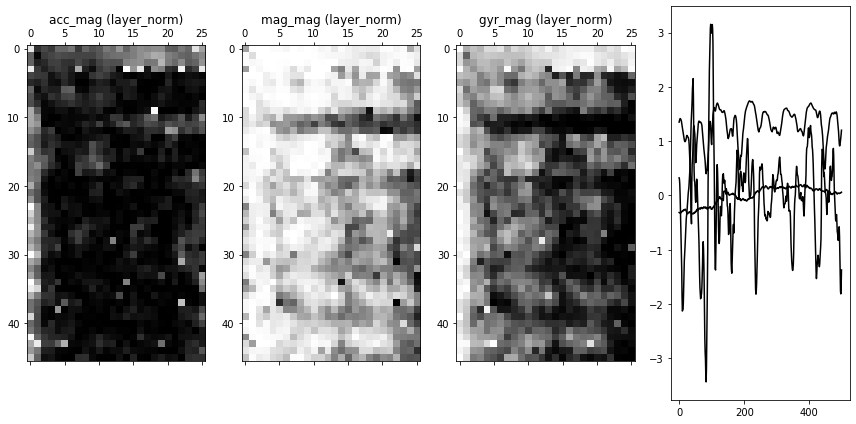

-2.8143778 4.407248


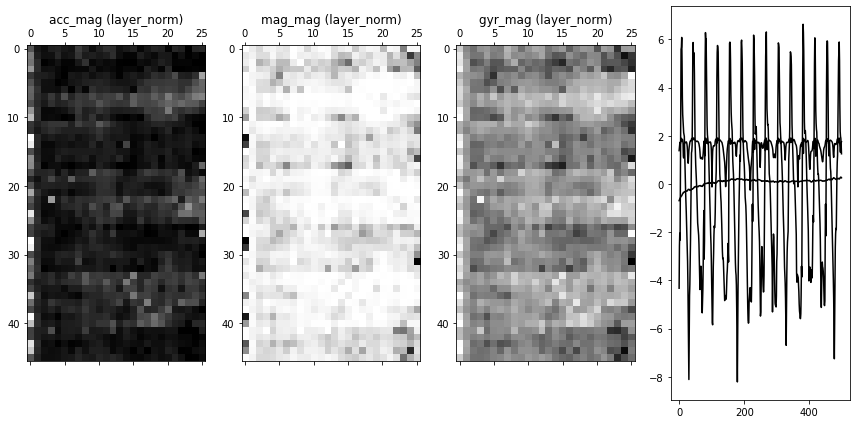

In [74]:
# Visualize the model

from matplotlib import pyplot as plt

for dataset in (train_dataset, validation_dataset):
    plt.clf
    X_batch, y_batch = next(iter(dataset))
    X, y = X_batch[0], y_batch[0]

    vis_model = models.Model(inputs=stft_model.input, outputs=stft_model.layers[3].output)
    spectrogram = vis_model.predict(X.numpy().reshape(1, 500, 3))
    spectrogram = spectrogram[0, :, :, :]
    print(np.min(spectrogram), np.max(spectrogram))

    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(6 * 2, 6)

    axs[0].matshow(spectrogram[:, :, 0], cmap=plt.cm.binary)
    axs[0].set_title('acc_mag (layer_norm)')
    axs[1].matshow(spectrogram[:, :, 1], cmap=plt.cm.binary)
    axs[1].set_title('mag_mag (layer_norm)')
    axs[2].matshow(spectrogram[:, :, 2], cmap=plt.cm.binary)
    axs[2].set_title('gyr_mag (layer_norm)')
    axs[3].plot(X.numpy()[:, 0], color='black')
    axs[3].plot(X.numpy()[:, 1], color='black')
    axs[3].plot(X.numpy()[:, 2], color='black')

    plt.tight_layout()
    plt.show()